In [8]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [9]:
import numpy as np
import pandas as pd

In [10]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [11]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [12]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [13]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [14]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [15]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [16]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [113]:
# Calculate the date 1 year ago from the last data point in the database
Date_df = pd.DataFrame(session.query(Measurement.date))
Date_df.iloc[-1,:] # Date from year ago would be 2016-08-23

date    2017-08-23
Name: 19549, dtype: object

In [105]:
# Design a query to retrieve the last 12 months of precipitation data
precip_analysis = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= "2016-08-23").\
    filter(Measurement.date <= "2017-08-23").all()
precip_df = pd.DataFrame(precip_analysis)
precip_df['date'] = pd.to_datetime(precip_df['date'])
precip_df = precip_df.set_index('date')                                      
precip_df.rename(columns = {'prcp': 'precipitation'}, inplace=True)  
precip_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


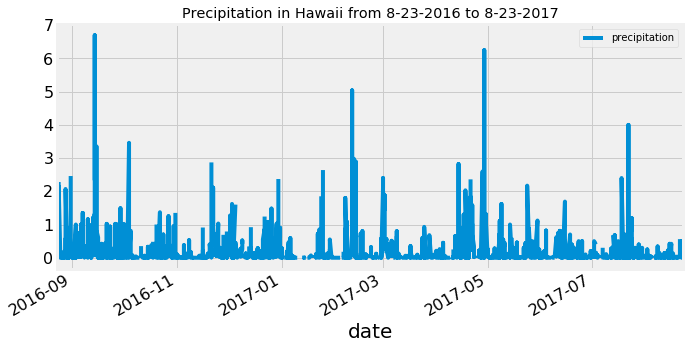

In [116]:
#Plots the data
precip_df.plot(figsize=(10, 5),                                              
               sort_columns=True, # Sort the dataframe by Dates before plotting 
               use_index=True, # Use the index to plot (Dates)
               title='Precipitation in Hawaii from 8-23-2016 to 8-23-2017', 
               legend=True,
               fontsize=16,
               grid=True,
              )

plt.xlabel('date', fontsize=20)
plt.show()

In [117]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [149]:
# Design a query to show how many stations are available in this dataset?
station_analysis = session.query(Measurement.station,Measurement.tobs)
station_df = pd.DataFrame(station_analysis)
station_df.nunique()[0]

9

In [187]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [188]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == "USC00519281").all()

[(54.0, 85.0, 71.66378066378067)]

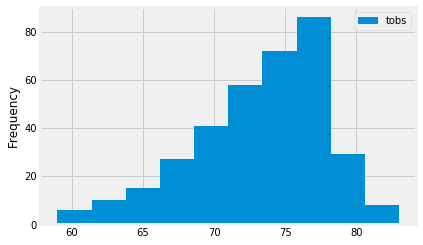

In [189]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_list = []
highest_temp = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= '2016-08-23')
temp_df = pd.DataFrame(highest_temp, columns=['tobs'])
temp_df.plot.hist();

In [197]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [198]:
trip_start_date = '2015-08-16'
trip_end_date = '2015-08-22'

In [199]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip = calc_temps(trip_start_date, trip_end_date)
print(trip)

[(72.0, 77.8695652173913, 84.0)]


C:\Users\Lor.PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


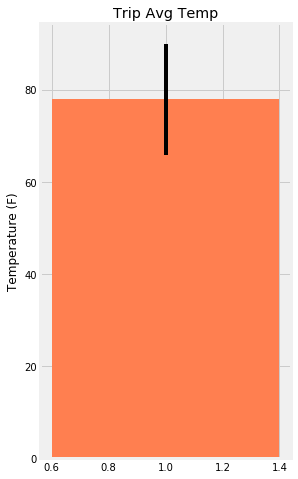

In [200]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(figsize=plt.figaspect(2.))
peak = trip[0][2] - trip[0][0]
bar = ax.bar(1, trip[0][1], yerr = peak, color = "coral")
plt.title("Trip Avg Temp")
plt.ylabel("Temperature (F)")
fig.show()

In [202]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
session.query(Measurement.station, Station.name,
              Station.latitude, Station.longitude, 
              Station.elevation, func.count(Measurement.prcp)).\
    group_by(Measurement.station, Station.name,
                  Station.latitude, Station.longitude, 
                  Station.elevation).order_by(func.count(Measurement.prcp).desc()).all()

[('USC00519281',
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9,
  2772),
 ('USC00519281', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 2772),
 ('USC00519281',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  2772),
 ('USC00519281',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  2772),
 ('USC00519281', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 2772),
 ('USC00519281',
  'UPPER WAHIAWA 874.3, HI US',
  21.4992,
  -158.0111,
  306.6,
  2772),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  2772),
 ('USC00519281', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 2772),
 ('USC00519281',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  2772),
 ('USC00513117',
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9,
  2696),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 2696),
 ('USC00513117',
  'KUALOA RANCH HEAD